# Project 3 - Closeness Centrality Analysis

By Oviya Adhan

Use the graph database to perform the closest centrality algorithm between the different art departments to see if there is/was cross cultural influence and which department has the most influence over other departments

## Enviroment Set Up

In [1]:
import neo4j
import csv
import math
import numpy as np
import pandas as pd
import psycopg2
from IPython.display import display

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [4]:
cursor = connection.cursor()

## Neo4j Set Up

#### Web server interface at https://xxxx:7473

#### Update - since the videos were filmed, neo4j requires a longer, more complex password, so the newest password is here:

**Username: neo4j**

**Password: ucb_mids_w205**

**In the web server interface, run the same query from last week to return all nodes and all relationships:**

```
match (n) return n
```

In [60]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [61]:
session = driver.session(database="neo4j")

In [62]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [63]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [64]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

In [65]:
def my_neo4j_number_nodes_relationships():
    "print the number of nodes and relationships"
   
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    print("-------------------------")
    print("  Nodes:", number_nodes)
    print("  Relationships:", number_relationships)
    print("-------------------------")

### Run graph_setup.ipynb

Verify the number of nodes and relationships

In [66]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 8607
  Relationships: 17844
-------------------------


## Shortest Path Analysis

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

In [67]:
# Clear department graph is already run/exists
query = "CALL gds.graph.drop('deptGraph') YIELD graphName"
session.run(query)

In [74]:
def run_department_closeness_centrality(driver):
    """
    Runs closeness centrality on Department-Artwork graph using BELONGS_TO edges.
    Returns a DataFrame sorted by closeness score.
    """

    # Step 1: Drop previous projection (if exists)
    with driver.session(database="neo4j") as session:
        session.run("CALL gds.graph.drop('deptGraph', false) YIELD graphName")

    # Step 2: Create new graph without projecting string properties
    with driver.session(database="neo4j") as session:
        projection_query = """
        CALL gds.graph.project(
            'deptGraph',
            ['Department', 'Artwork'],
            {
                BELONGS_TO: {type: 'BELONGS_TO', orientation: 'UNDIRECTED'}
            }
        )
        YIELD graphName, nodeCount, relationshipCount
        """
        _ = session.run(projection_query).consume()

    # Step 3: Run closeness centrality and extract department info
    with driver.session(database="neo4j") as session:
        closeness_query = """
        CALL gds.closeness.stream('deptGraph', {useWassermanFaust: true})
        YIELD nodeId, score
        WITH gds.util.asNode(nodeId) AS node, score
        WHERE node:Department
        RETURN coalesce(node.department, node.name) AS department, score AS closeness
        ORDER BY closeness DESC
        """
        result = session.run(closeness_query)
        data = [{"department": record["department"], "closeness": record["closeness"]} for record in result]

    df = pd.DataFrame(data)
    return df

In [82]:
closeness_df = run_department_closeness_centrality(driver)
print(closeness_df.head())

                    department  closeness
0           European Paintings   0.344616
1  Modern and Contemporary Art   0.316409
2            The American Wing   0.204248
3                    Asian Art   0.062884
4     Robert Lehman Collection   0.044964


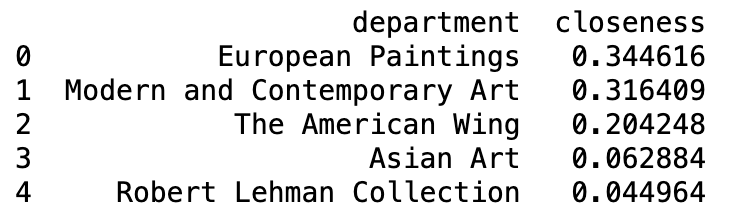

The closeness is only defined for European Paintings, Modern and Contemporary Art, The American Wing, Asian Art, and the Robert Lehman Collection departments - this means the other eight departments are disconnected from other departments which means they have no overlapping artworks with one another. 

In [85]:
# Graph results
import matplotlib.pyplot as plt

def plot_closeness_centrality(closeness_df):
    """
    Plots a horizontal bar chart of closeness centrality scores for departments,
    with the score shown as a label on each bar.
    """
    # Sort for clean visual
    closeness_df = closeness_df.sort_values(by="closeness", ascending=True)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(closeness_df['department'], closeness_df['closeness'], color='skyblue')
    plt.xlabel("Closeness Centrality")
    plt.title("Department Closeness Centrality in Artwork Graph")

    # Add closeness labels on bars
    for bar, score in zip(bars, closeness_df['closeness']):
        plt.text(
            bar.get_width() + 0.005,      # x-position
            bar.get_y() + bar.get_height() / 2,  # y-position (centered vertically)
            f"{score:.4f}",               # label text
            va='center',
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

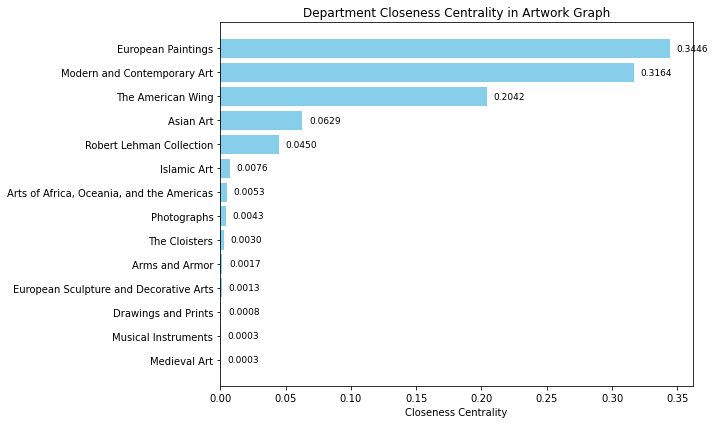

In [86]:
plot_closeness_centrality(closeness_df)

By visualizing the closeness centrality of all departments we can see that all the departments are connected by artwork, but minimal beyond the five departments mentioned prior. At the top we can see European Paintings appears to have the most cross over with other departments suggesting either a disportionate representation of European Paintings in the Met's collection or a more general disportionate representation of European artwork as it spans across several other departments like European Sculpture and Decorative Arts, Drawings and Prints, Medieval Art, The Cloisters, etc. 